In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm

In [2]:
# Basis
def Orthonorm_Legendre(x, d):
    B = np.polynomial.legendre.legvander(x, d)
    B = B*np.sqrt(2*np.arange(0, B.shape[1], 1)+1)
    return B

Legendre = np.polynomial.legendre.legvander
Vandermonde = np.polynomial.polynomial.polyvander
Chebyshev = np.polynomial.chebyshev.chebvander

In [3]:
# Moore-Penrose Pseudoinverse for solving regression
def solve(basis, x, y, p, lmbda=0):
    """Solve polynomial regression using Moore-Penrose Pseudoinverse
    Args:
        basis (Callable): A function that returns the pseudo-Vandermonde
                          matrix of degree deg and sample points x.
                          See https://numpy.org/doc/stable/reference/generated/numpy.polynomial.polynomial.polyvander.html
        x (Iterable): An iterable representing x-values in the training set
        y (Iterable): An iterable representing y-values in the training set
        p (int): An integer representing the degree of the predictor polynomial
        lmbda (float): A float representing a regularizer constant (see Section 7)
    Returns:
        A np.array representing the weights learned from the training set
    """
    x_basis = basis(x, p)
    x_basis = np.concatenate([x_basis, lmbda*np.ones((1, p+1))])
    y = np.concatenate([y, [0]])
    return np.linalg.pinv(x_basis).dot(y)

In [4]:
def generate_data(basis, n_deg, s_samples, x_lim=[-1, 1]):
    """Gemnerate training and test sets for polynomial regression task
    Args:
        basis (Callable): A function that returns the pseudo-Vandermonde
                          matrix of degree deg and sample points x.
                          See https://numpy.org/doc/stable/reference/generated/numpy.polynomial.polynomial.polyvander.html
        n_deg (int): An integer representing the degree of the underlying polynomial
        s_samples (int): An integer representing the number of training samples
        x_lim (Iterable): A iterable of 2 numbers representing the input range
    Returns:
        Four np.arrays representing the training-x, training-y, test-x
        and test-y values
    """
    # Generate test set
    test_x = np.arange(*x_lim, 0.001)
    coefficients = np.random.randn(n_deg + 1)
    test_y = basis(test_x, n_deg).dot(coefficients)
    # Generate training set
    train_x = np.random.rand(s_samples) * (x_lim[1] - x_lim[0]) + x_lim[0]
    train_y = basis(train_x, n_deg).dot(coefficients)
    train_y += np.random.randn(*train_y.shape) * 0.1
    return train_x, train_y, test_x, test_y

In [5]:
# Figure 1
def double_descent_test_error_vs_norm(basis, n_degs=np.arange(1, 11), p_lim=[1, 61], s_samples=30, x_lim=[-1, 1]):
    """How does test error and norm of learned weights change with
    varying model complexity.
    Args:
        basis (Callable): A function that returns the pseudo-Vandermonde
                          matrix of degree deg and sample points x.
                          See https://numpy.org/doc/stable/reference/generated/numpy.polynomial.polynomial.polyvander.html
        n_degs (Iterable): An iterable representing degrees of underlying polynomials
        p_lim (Iterable): An iterable of 2 numbers representing range of p to test
                          where p is the degree of the predictor polynomial
        s_samples (int): An integer representing the number of training samples
        x_lim (Iterable): A list or array of 2 numbers representing the input range
    """
    test_errors_dict = {}
    norms_dict = {}
    cmap = cm.get_cmap('cividis', max(n_degs))
    for n in n_degs:
        train_x, train_y, test_x, test_y = generate_data(basis, n, s_samples, x_lim)
        test_errors = []
        norms = []
        pred_degs = np.arange(*p_lim)
        for p in pred_degs:
            weights = solve(basis, train_x, train_y, p)
            pred_test_y = basis(test_x, p).dot(weights)
            test_error = np.mean(np.abs(pred_test_y - test_y) ** 2)
            test_errors.append(test_error)
            norms.append(np.linalg.norm(weights))
        test_errors_dict[n] = test_errors
        norms_dict[n] = norms
    # Plot
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    for n in n_degs:
        ax[0].plot(pred_degs, test_errors_dict[n], color=cmap(n))
        ax[1].plot(pred_degs, norms_dict[n], color=cmap(n))
    ax[0].set_xlabel('p, Degree of Predictor Polynomial', fontsize=11)
    ax[0].set_yscale('log')
    ax[0].set_ylabel('Test Error', fontsize=11)
    ax[1].set_xlabel('p, Degree of Predictor Polynomial', fontsize=11)
    ax[1].set_yscale('log')
    ax[1].set_ylabel('Norm of Learned Weights', fontsize=11)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=max(n_degs)))
    clb = plt.colorbar(sm, ax=ax[0])
    clb.ax.set_ylabel('n, Degree of Underlying Polynomial', fontsize=11)
    clb = plt.colorbar(sm, ax=ax[1])
    clb.ax.set_ylabel('n, Degree of Underlying Polynomial', fontsize=11)
    fig.tight_layout(pad=3.0)
    plt.show()

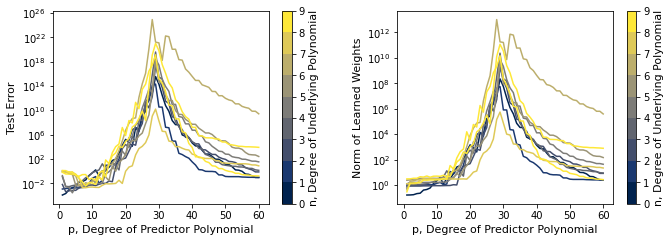

In [6]:
double_descent_test_error_vs_norm(Legendre)

In [7]:
# Figure 2
def plot_regression_examples(basis, p_degs=[1, 5, 20, 100], n_deg=5, s_samples=20, x_lim=[-1, 1]):
    """Plot some regression examples.
    Args:
        basis (Callable): A function that returns the pseudo-Vandermonde
                          matrix of degree deg and sample points x.
                          See https://numpy.org/doc/stable/reference/generated/numpy.polynomial.polynomial.polyvander.html
        p_degs (Iterable): An iterable representing degrees of predictor polynomials
        n_deg (int): An integer representing degree of the underlying polynomial
        s_samples (int): An integer representing the number of training samples
        x_lim (Iterable): A list or array of 2 numbers representing the input range
    """
    train_x, train_y, test_x, test_y = generate_data(basis, n_deg, s_samples, x_lim)
    fig, ax = plt.subplots(1, len(p_degs), figsize=(len(p_degs)*3, 2))
    for i, p in enumerate(p_degs):
        weights = solve(basis, train_x, train_y, p)
        pred_test_y = basis(test_x, p).dot(weights)
        ax[i].plot(test_x, test_y, c='black')
        ax[i].scatter(train_x, train_y, c='red')
        ax[i].plot(test_x, pred_test_y)
        ax[i].set_title(f'p={p}')
        ax[i].set_ylim([min(test_y)-1, max(test_y)+1])
    plt.show()

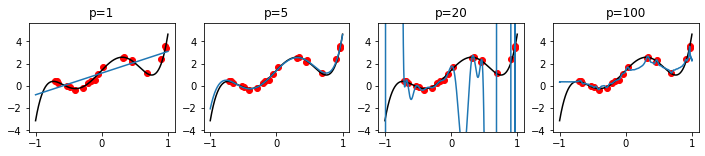

In [8]:
plot_regression_examples(Legendre)

In [9]:
# Figure 3
def modelwise_demo(basis, p_lim=[1, 100], show_p=[1, 15, 30, 60, 90], s_samples=30, n_deg=15, x_lim=[-1, 1]):
    """Model-wise double descent demo.
    Args:
        basis (Callable): A function that returns the pseudo-Vandermonde
                          matrix of degree deg and sample points x.
                          See https://numpy.org/doc/stable/reference/generated/numpy.polynomial.polynomial.polyvander.html
        p_lim (Iterable): An iterable of 2 numbers representing range of p to test
                          where p is the degree of the predictor polynomial
        show_p (Iterable): An iterable representing the p-values for plotting
        s_samples (int): An integer representing the number of training samples
        n_deg (int): An integer representing degree of the underlying polynomial
        x_lim (Iterable): A list or array of 2 numbers representing the input range
    """
    cmap = cm.get_cmap('cividis')
    train_x, train_y, test_x, test_y = generate_data(basis, n_deg, s_samples, x_lim)
    test_errors = []
    train_errors = []
    pred_test_y_dict = {}
    pred_degs = np.arange(*p_lim)
    for p in pred_degs:
        weights = solve(basis, train_x, train_y, p)
        pred_y = basis(train_x, p).dot(weights)
        train_error = np.mean(np.abs(pred_y - train_y) ** 2)
        pred_test_y = basis(test_x, p).dot(weights)
        test_error = np.mean(np.abs(pred_test_y - test_y) ** 2)
        train_errors.append(train_error)
        test_errors.append(test_error)
        if p in show_p:
            pred_test_y_dict[p] = pred_test_y
    # Plot
    fig, ax = plt.subplots(2, 1)
    ax[0].plot(pred_degs, train_errors)
    ax[0].set_yscale('log')
    ax[0].set_ylabel('Training Error', fontsize=12)
    ax[1].plot(pred_degs, test_errors)
    ax[1].set_xlabel('p, Degree of Predictor Polynomial', fontsize=12)
    ax[1].set_yscale('log')
    ax[1].set_ylabel('Test Error', fontsize=12)
    plt.show()
    # Plot functions
    fig, ax = plt.subplots(1, len(show_p), figsize=(15, 3))
    for i, p in enumerate(show_p):
        ax[i].plot(test_x, test_y, color='black', lw=1)
        ax[i].scatter(train_x, train_y, color='red', s=15)
        ax[i].plot(test_x, pred_test_y_dict[p], lw=2)
        ax[i].set_ylim([min(test_y)-1, max(test_y)+1])
        ax[i].set_title(f'p={p}', fontsize=15)
    plt.show()

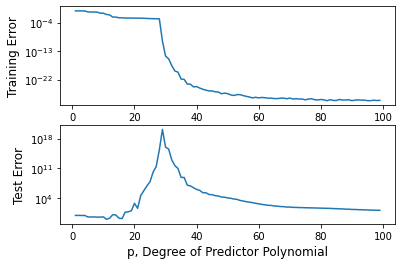

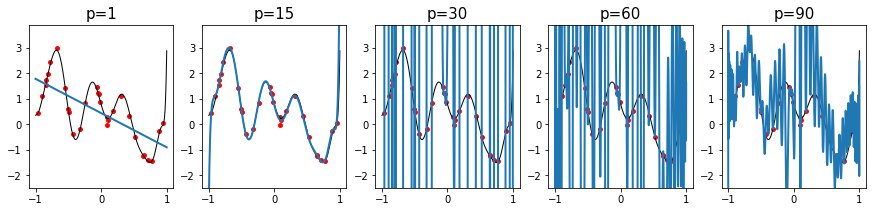

In [10]:
modelwise_demo(Legendre)

In [11]:
# Figure 4
def modelwise(basis, s_samples=10, n_degs=np.arange(1, 101), p_lim=[1, 61], x_lim=[-1, 1]):
    """Model-wise double descent experiment.
    Args:
        basis (Callable): A function that returns the pseudo-Vandermonde
                          matrix of degree deg and sample points x.
                          See https://numpy.org/doc/stable/reference/generated/numpy.polynomial.polynomial.polyvander.html
        s_samples (int): An integer representing the number of training samples
        n_degs (Iterable): An iterable representing degrees of underlying polynomials
        p_lim (Iterable): An iterable of 2 numbers representing range of p to test
                          where p is the degree of the predictor polynomial
        x_lim (Iterable): A list or array of 2 numbers representing the input range
    """
    test_errors_dict = {}
    cmap = cm.get_cmap('cividis', max(n_degs))
    for n in n_degs:
        train_x, train_y, test_x, test_y = generate_data(basis, n, s_samples, x_lim)
        # Solve for models and calculate errors
        test_errors = []
        norms = []
        pred_degs = np.arange(*p_lim)
        for p in pred_degs:
            weights = solve(basis, train_x, train_y, p)
            pred_test_y = basis(test_x, p).dot(weights)
            test_error = np.mean(np.abs(pred_test_y - test_y) ** 2)
            test_errors.append(test_error)
        test_errors_dict[n] = test_errors
    # Plot
    fig, ax = plt.subplots()
    for n in n_degs:
        ax.plot(pred_degs, test_errors_dict[n], color=cmap(n), alpha=0.5)
    ax.set_title(f'Training on s={s_samples} samples')
    ax.set_xlabel('p, Degree of Predictor Polynomial', fontsize=11)
    ax.set_yscale('log')
    ax.set_ylabel('Test Error', fontsize=11)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=max(n_degs)))
    clb = plt.colorbar(sm, ax=ax)
    clb.ax.set_ylabel('n, Degree of Underlying Polynomial', fontsize=11)
    plt.show()

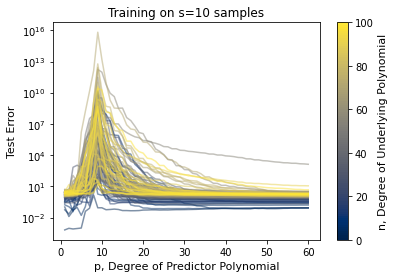

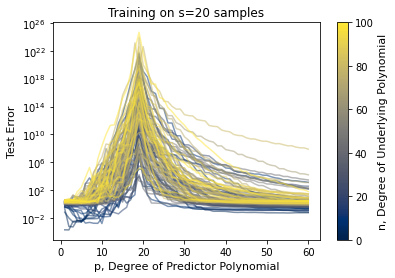

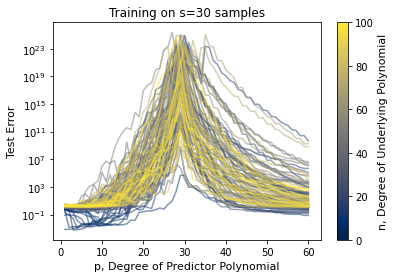

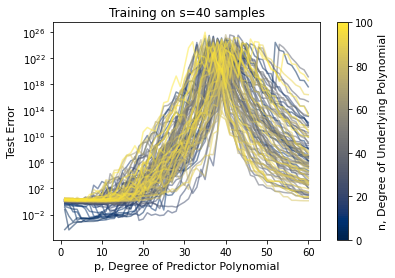

In [12]:
for s in np.arange(10, 41, 10):
    modelwise(Legendre, s)

In [13]:
# Figure 5
def samplewise_demo(basis, s_lim=[1, 100], show_s=[1, 15, 30, 60, 90], p_deg=30, n_deg=15, x_lim=[-1, 1]):
    """Sample-wise double descent demo.
    Args:
        basis (Callable): A function that returns the pseudo-Vandermonde
                          matrix of degree deg and sample points x.
                          See https://numpy.org/doc/stable/reference/generated/numpy.polynomial.polynomial.polyvander.html
        s_lim (Iterable): An iterable of 2 numbers representing range of s to test
                          where s is the number of training samples
        show_s (Iterable): An iterable representing the s-values for plotting
        p_deg (int): An integer representing the degree of the predictor polynomial
        n_deg (int): An integer representing degree of the underlying polynomial
        x_lim (Iterable): A list or array of 2 numbers representing the input range
    """
    cmap = cm.get_cmap('cividis')
    train_x, train_y, test_x, test_y = generate_data(basis, n_deg, s_lim[1], x_lim)
    test_errors = []
    train_errors = []
    pred_test_y_dict = {}
    s_samples = np.arange(*s_lim)
    for s in s_samples:
        weights = solve(basis, train_x[:s], train_y[:s], p_deg)
        pred_y = basis(train_x, p_deg).dot(weights)
        train_error = np.mean(np.abs(pred_y - train_y) ** 2)
        pred_test_y = basis(test_x, p_deg).dot(weights)
        test_error = np.mean(np.abs(pred_test_y - test_y) ** 2)
        train_errors.append(train_error)
        test_errors.append(test_error)
        if s in show_s:
            pred_test_y_dict[s] = pred_test_y
    # Plot
    fig, ax = plt.subplots(2, 1)
    ax[0].plot(s_samples, train_errors)
    ax[0].set_yscale('log')
    ax[0].set_ylabel('Training Error', fontsize=12)
    ax[1].plot(s_samples, test_errors)
    ax[1].set_xlabel('p, Degree of Predictor Polynomial', fontsize=12)
    ax[1].set_yscale('log')
    ax[1].set_ylabel('Test Error', fontsize=12)
    plt.show()
    # Plot functions
    fig, ax = plt.subplots(1, len(show_s), figsize=(15, 3))
    for i, s in enumerate(show_s):
        ax[i].plot(test_x, test_y, color='black', lw=1)
        ax[i].scatter(train_x[:s], train_y[:s], color='red', s=15)
        ax[i].plot(test_x, pred_test_y_dict[s], lw=2)
        ax[i].set_ylim([min(test_y)-1, max(test_y)+1])
        ax[i].set_title(f's={s}', fontsize=15)
    plt.show()

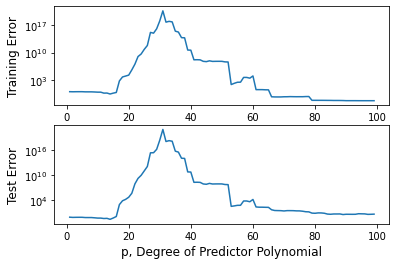

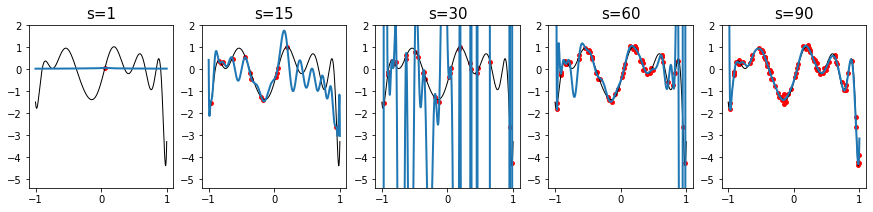

In [14]:
samplewise_demo(Legendre)

In [15]:
# Figure 6
def samplewise(basis, p_deg=10, n_degs=np.arange(1, 101), s_lim=[1, 61], x_lim=[-1, 1]):
    """Sample-wise double descent experiment.
    Args:
        basis (Callable): A function that returns the pseudo-Vandermonde
                          matrix of degree deg and sample points x.
                          See https://numpy.org/doc/stable/reference/generated/numpy.polynomial.polynomial.polyvander.html
        p_deg (int): An integer representing the degree of the predictor polynomial
        n_degs (Iterable): An iterable representing degrees of underlying polynomials
        s_lim (Iterable): An iterable of 2 numbers representing range of s to test
                          where s is the number of training samples
        x_lim (Iterable): A list or array of 2 numbers representing the input range
    """
    test_errors_dict = {}
    cmap = cm.get_cmap('cividis', max(n_degs))
    s_samples = np.arange(*s_lim)
    for n in n_degs:
        train_x, train_y, test_x, test_y = generate_data(basis, n, max(s_samples), x_lim)
        # Solve for models and calculate errors
        test_errors = []
        norms = []
        for s in s_samples:
            weights = solve(basis, train_x[:s], train_y[:s], p)
            pred_test_y = basis(test_x, p).dot(weights)
            test_error = np.mean(np.abs(pred_test_y - test_y) ** 2)
            test_errors.append(test_error)
        test_errors_dict[n] = test_errors
    # Plot
    fig, ax = plt.subplots()
    for n in n_degs:
        ax.plot(s_samples, test_errors_dict[n], color=cmap(n), alpha=0.5)
    ax.set_title(f'Fitting with a p={p_deg}-degree predictor')
    ax.set_xlabel('s, Number of Training Samples', fontsize=11)
    ax.set_yscale('log')
    ax.set_ylabel('Test Error', fontsize=11)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=max(n_degs)))
    clb = plt.colorbar(sm, ax=ax)
    clb.ax.set_ylabel('n, Degree of Underlying Polynomial', fontsize=11)
    plt.show()

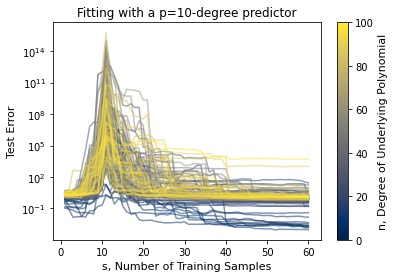

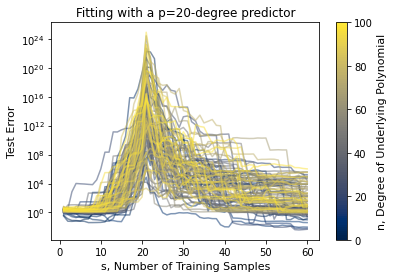

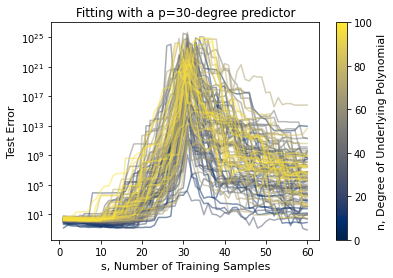

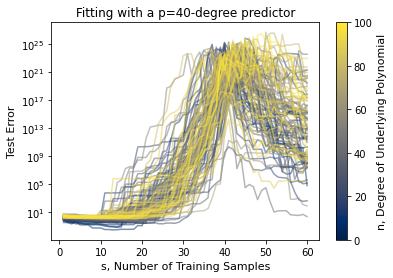

In [16]:
for p in np.arange(10, 41, 10):
    samplewise(Legendre, p)

In [17]:
# Figure 7
def alphawise(basis, n_deg, s_lim=[10, 31], p_lim=[1, 101], x_lim=[-1, 1], lmbda=0):
    """Alpha-wise double descent experiment.
    Args:
        basis (Callable): A function that returns the pseudo-Vandermonde
                          matrix of degree deg and sample points x.
                          See https://numpy.org/doc/stable/reference/generated/numpy.polynomial.polynomial.polyvander.html
        n_deg (int): An integer representing degree of underlying polynomial
        s_lim (Iterable): An iterable of 2 numbers representing range of s to test
                          where s is the number of training samples
        p_lim (Iterable): An iterable of 2 numbers representing range of p to test
                          where p is the degree of the predictor polynomial
        x_lim (Iterable): A list or array of 2 numbers representing the input range
        lmbda (float): A float representing a regularizer constant (see Section 7)
    """
    s_samples = np.arange(*s_lim)
    pred_degs = np.arange(*p_lim)
    cmap = cm.get_cmap('cividis', max(s_samples))
    train_x, train_y, test_x, test_y = generate_data(basis, n_deg, max(s_samples), x_lim)
    
    train_errors_dict = {}
    test_errors_dict = {}
    norms_dict = {}
    for s in tqdm(s_samples):
        # Solve for models and calculate errors
        test_errors = []
        train_errors = []
        norms = []
        for p in pred_degs:
            if s / p < 1:
                weights = solve(basis, train_x[:s], train_y[:s], p, lmbda)
            else:
                weights = solve(basis, train_x[:s], train_y[:s], p)
            pred_train_y = basis(train_x[:s], p).dot(weights)
            train_error = np.mean(np.abs(pred_train_y - train_y[:s]) ** 2)
            pred_test_y = basis(test_x, p).dot(weights)
            test_error = np.mean(np.abs(pred_test_y - test_y) ** 2)
            train_errors.append(train_error)
            test_errors.append(test_error)
            norms.append(np.linalg.norm(weights))
        train_errors_dict[s] = train_errors
        test_errors_dict[s] = test_errors
        norms_dict[s] = norms
    def scale(n):
        return (n - min(s_samples)) / (max(s_samples) - min(s_samples))
    # Plot
    fig, ax = plt.subplots(3, 1, figsize=(9, 9))
    for s in s_samples:
        ax[0].plot(s/pred_degs, train_errors_dict[s], label=f's={s}', color=cmap(scale(s)), alpha=0.7)
    ax[0].set_yscale('log')
    ax[0].set_ylabel('Training Loss', fontsize=15)
    ax[0].set_xlim([0, 2])
    for s in s_samples:
        ax[1].plot(s/pred_degs, test_errors_dict[s], label=f's={s}', color=cmap(scale(s)), alpha=0.7)
    ax[1].set_yscale('log')
    ax[1].set_ylabel('Test Error', fontsize=15)
    ax[1].set_xlim([0, 2])
    for s in s_samples:
        ax[2].plot(s/pred_degs, norms_dict[s], label=f's={s}', color=cmap(scale(s)), alpha=0.7)
    ax[2].set_xlabel('α = s/p', fontsize=15)
    ax[2].set_yscale('log')
    ax[2].set_ylabel('Norm of learned\nweights', fontsize=15)
    ax[2].set_xlim([0, 2])
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=int(min(s_samples)), vmax=int(max(s_samples))))
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    clb = fig.colorbar(sm, cax=cbar_ax)
    clb.ax.set_ylabel('s, Number of Training Samples', fontsize=15)
    plt.show()

100%|██████████| 21/21 [00:06<00:00,  3.07it/s]


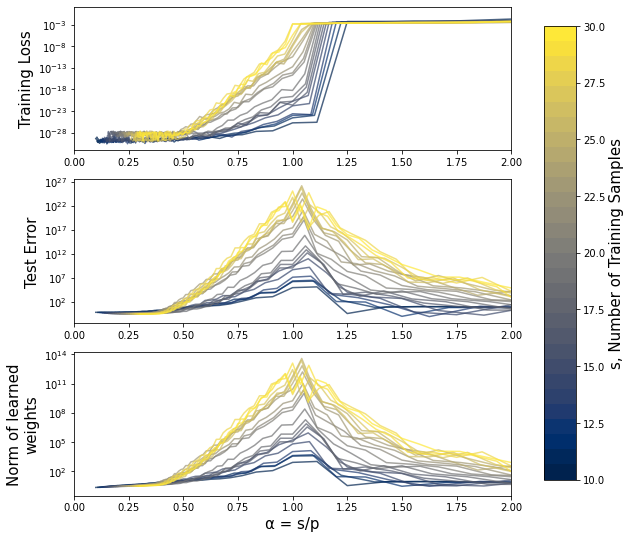

100%|██████████| 21/21 [00:06<00:00,  3.02it/s]


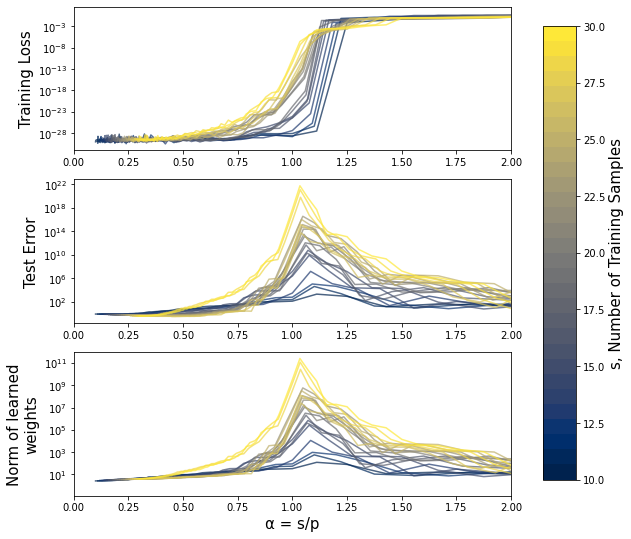

In [18]:
for n in [10, 50]:
    alphawise(Legendre, n)

100%|██████████| 21/21 [00:03<00:00,  6.35it/s]


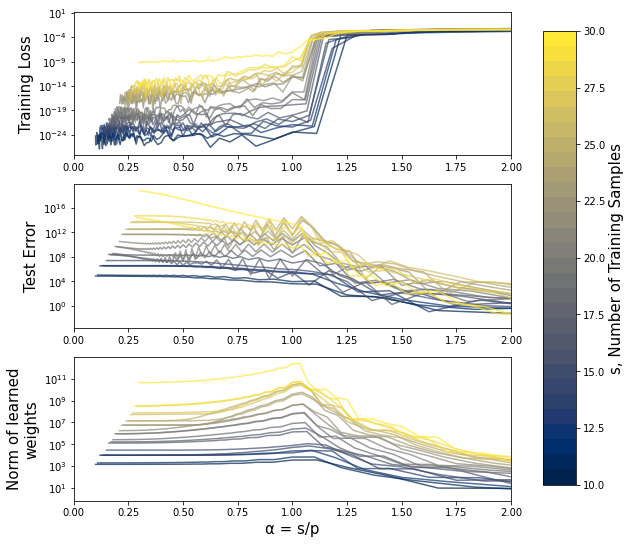

100%|██████████| 21/21 [00:03<00:00,  5.82it/s]


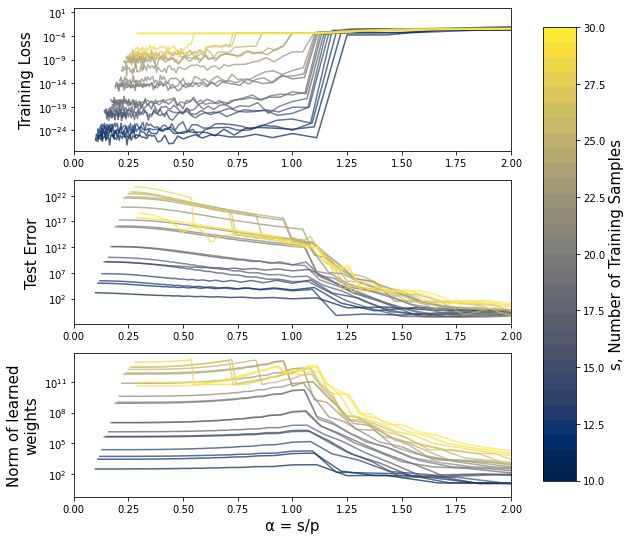

In [19]:
for n in [10, 50]:
    alphawise(Vandermonde, n)

100%|██████████| 21/21 [00:03<00:00,  6.13it/s]


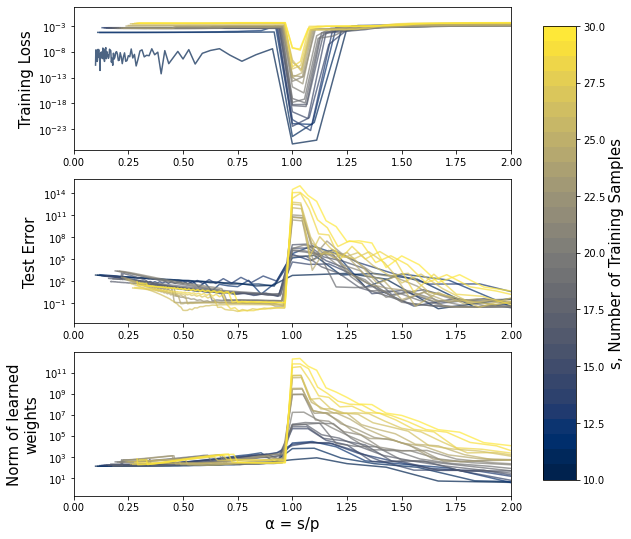

100%|██████████| 21/21 [00:03<00:00,  6.37it/s]


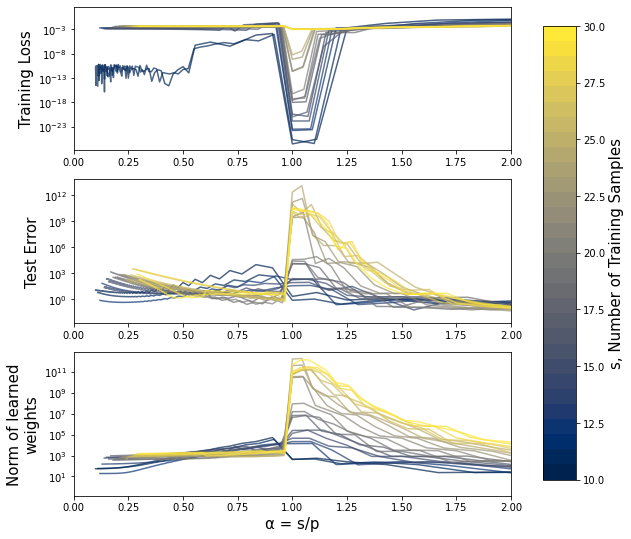

In [20]:
for n in [10, 50]:
    alphawise(Vandermonde, n, lmbda=1e10)

## Appendix B

In [21]:
def run_experiments(basis):
    """Helper function to run experiments on different basis.
    Args:
        basis (Callable): A function that returns the pseudo-Vandermonde
                          matrix of degree deg and sample points x.
                          See https://numpy.org/doc/stable/reference/generated/numpy.polynomial.polynomial.polyvander.html
    """
    modelwise_demo(basis)
    modelwise(basis)
    samplewise_demo(basis)
    samplewise(basis)
    for n in [10, 50]:
        alphawise(basis, n)

### Experiments with Orthonormal Legendre

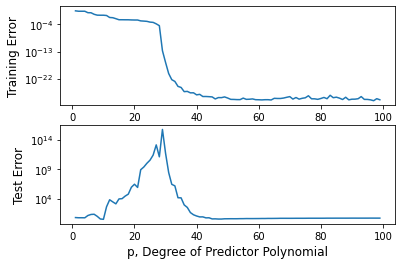

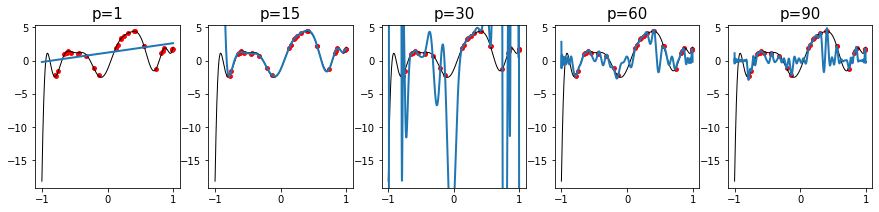

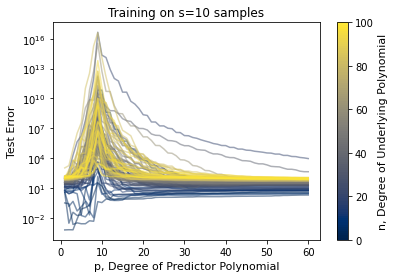

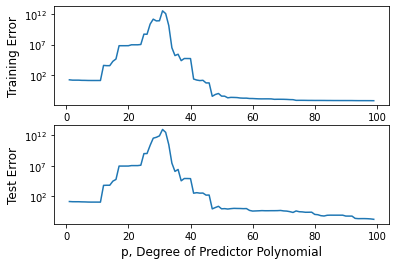

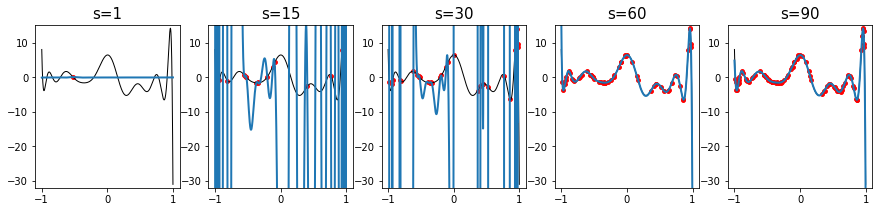

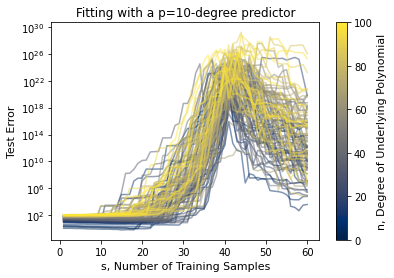

100%|██████████| 21/21 [00:06<00:00,  3.14it/s]


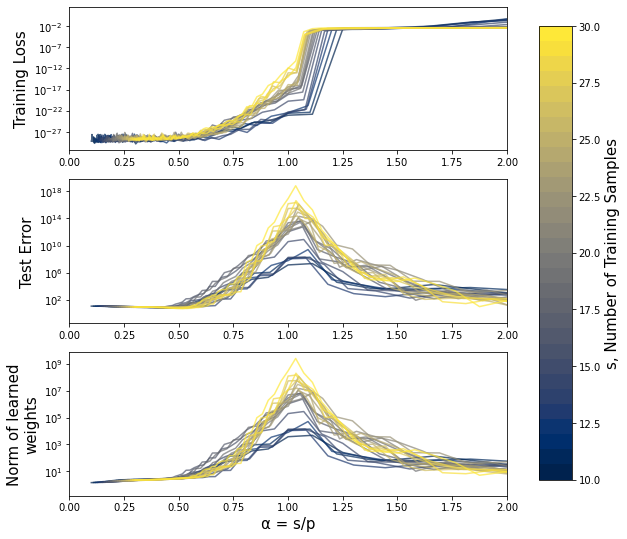

100%|██████████| 21/21 [00:06<00:00,  3.04it/s]


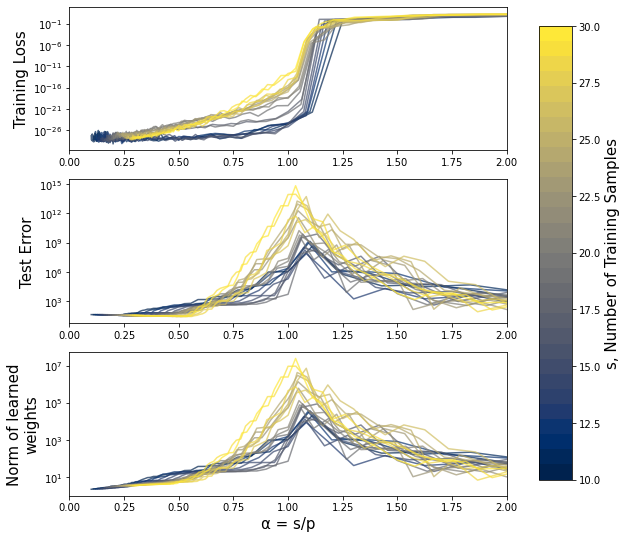

In [22]:
run_experiments(Orthonorm_Legendre)

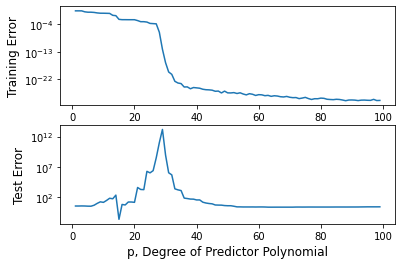

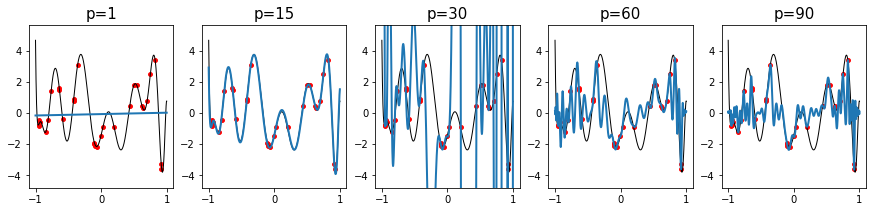

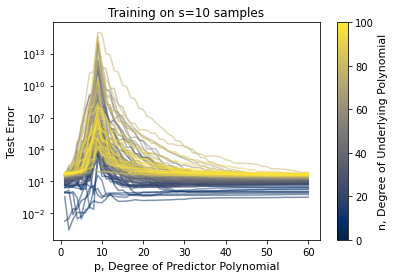

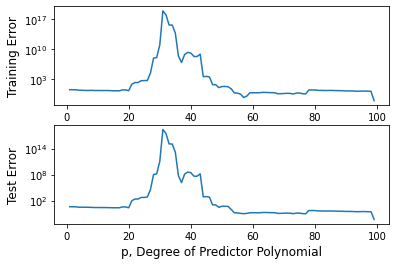

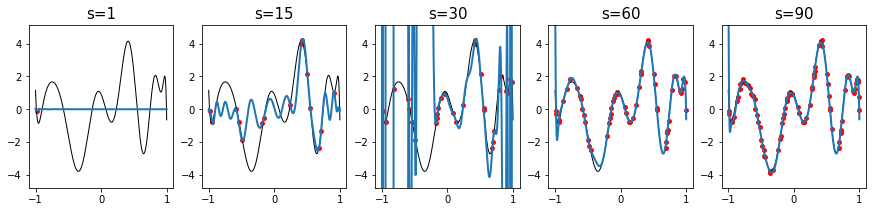

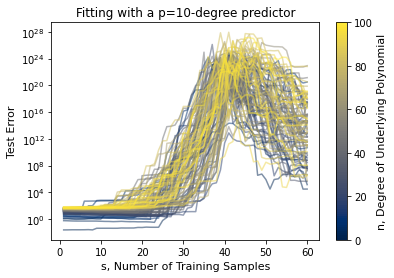

100%|██████████| 21/21 [00:03<00:00,  5.51it/s]


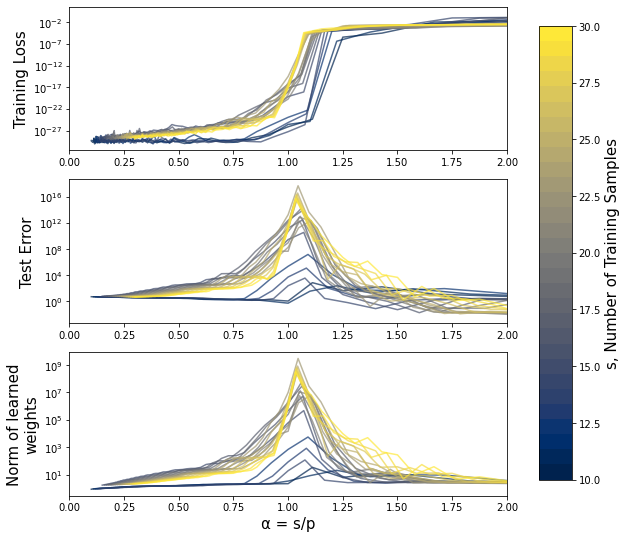

100%|██████████| 21/21 [00:04<00:00,  4.79it/s]


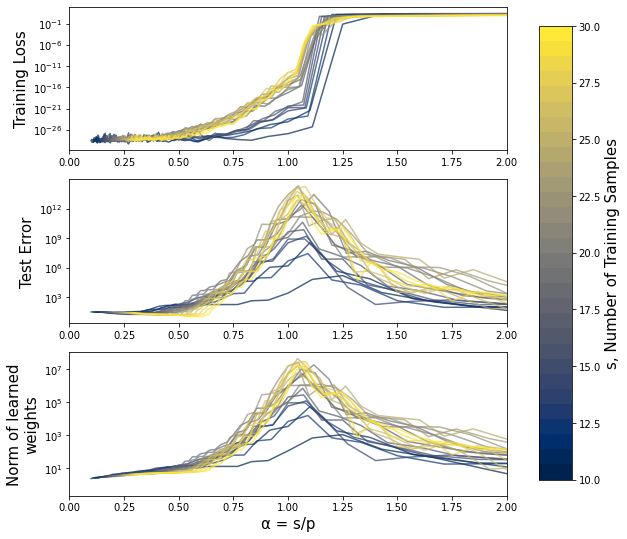

In [23]:
run_experiments(Chebyshev)